# Credit Risk IRB Modeling System

This project implements a complete Internal Ratings-Based (IRB) modeling system for credit risk assessment, following Basel III regulatory standards. The system estimates Probability of Default (PD) and Loss Given Default (LGD) while emphasizing model explainability, fairness auditing, and regulatory compliance.

Built using the Statlog German Credit Data, this framework demonstrates professional credit risk modeling practices with special attention to ethical AI and regulatory requirements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
import shap

In [2]:
# Load dataset
df = pd.read_csv("german_credit_data.csv")  # Update with actual file path

In [3]:
df.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


## Data Preparation

In [4]:
# Mapping German Column Names to English
column_mapping = {
    'laufkont': 'Status', 'laufzeit': 'Duration', 'moral': 'Credit History',
    'verw': 'Purpose', 'hoehe': 'Amount', 'sparkont': 'Savings',
    'beszeit': 'Employment Duration', 'rate': 'Installment Rate',
    'famges': 'Personal Status Sex', 'buerge': 'Other Debtors',
    'wohnzeit': 'Present Residence', 'verm': 'Property', 'alter': 'Age',
    'weitkred': 'Other Installment Plans', 'wohn': 'Housing',
    'bishkred': 'Number Credits', 'beruf': ' Job', 'pers': 'People Liable',
    'telef': 'Telephone', 'gastarb': 'Foreign Worker', 'kredit': 'Credit Risk'
}

df.rename(columns=column_mapping, inplace=True)
df = df.dropna()

# Create Age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[18, 25, 35, 45, 60, 100], 
                         labels=['18-25', '26-35', '36-45', '46-60', '60+'])

Cleans and structures raw credit data for modeling.

In [5]:
df.head()

,Status,Duration,Credit History,Purpose,Amount,Savings,Employment Duration,Installment Rate,Personal Status Sex,Other Debtors,...,Age,Other Installment Plans,Housing,Number Credits,Job,People Liable,Telephone,Foreign Worker,Credit Risk,Age_Group
0,1,18,4,2,1049,1,2,4,2,1,...,21,3,1,1,3,2,1,2,1,18-25
1,1,9,4,0,2799,1,3,2,3,1,...,36,3,1,2,3,1,1,2,1,36-45
2,2,12,2,9,841,2,4,2,2,1,...,23,3,1,1,2,2,1,2,1,18-25
3,1,12,4,0,2122,1,3,3,3,1,...,39,3,1,2,2,1,1,1,1,36-45
4,1,12,4,0,2171,1,3,4,3,1,...,38,1,2,2,2,2,1,1,1,36-45


**SIMULATE LGD DATA (Since original dataset doesn't have actual LGD)**

In [6]:
def simulate_lgd(row):
    """
    Simulate Loss Given Default based on loan and borrower characteristics.
    In reality, this would come from historical recovery data.
    """
    base_lgd = 0.45  # Base LGD of 45%
    
    # Adjust LGD based on risk factors
    if row['Credit Risk'] == 1:  # Higher LGD for actual defaults
        base_lgd += 0.15
    
    if row['Savings'] in ['0', '1']:  # Low savings → higher LGD
        base_lgd += 0.10
        
    if row['Property'] in ['0', '1']:  # Little/no property → higher LGD  
        base_lgd += 0.08
        
    if row[' Job'] in ['0']:  # Unskilled job → higher LGD
        base_lgd += 0.05
        
    # Larger loans might have different recovery rates
    if row['Amount'] > 10000:
        base_lgd -= 0.05  # Better collateral/collection efforts
    
    # Add some randomness
    noise = np.random.normal(0, 0.05)
    lgd = base_lgd + noise
    
    # Ensure LGD is between 0 and 1
    return max(0.10, min(0.90, lgd))

# Apply LGD simulation only to defaulted loans (Credit Risk = 1)
defaulted_loans = df[df['Credit Risk'] == 1].copy()
non_defaulted_loans = df[df['Credit Risk'] == 0].copy()

defaulted_loans['LGD'] = defaulted_loans.apply(simulate_lgd, axis=1)
non_defaulted_loans['LGD'] = 0.0  # No loss if no default

# Combine back
df = pd.concat([defaulted_loans, non_defaulted_loans], ignore_index=True)

print(f"LGD Statistics for defaulted loans:")
print(f"Mean LGD: {defaulted_loans['LGD'].mean():.3f}")
print(f"LGD Range: [{defaulted_loans['LGD'].min():.3f}, {defaulted_loans['LGD'].max():.3f}]")

LGD Statistics for defaulted loans:
Mean LGD: 0.599
LGD Range: [0.437, 0.750]


### 📊 LGD Distribution
- **Mean LGD: 59.9%** - This is relatively high, suggesting challenging recovery environment
- **Range: 43.7% - 75.0%** - Substantial variation exists, but models aren't capturing the drivers effectively

### EXPLORATORY DATA ANALYSIS & FAIRNESS AUDIT

C:\Users\milto\AppData\Local\Temp\ipykernel_25764\656610151.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_bad_rate = df.groupby('Age_Group')['Credit Risk'].mean()
C:\Users\milto\AppData\Local\Temp\ipykernel_25764\656610151.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lgd_by_age = defaulted_loans.groupby('Age_Group')['LGD'].mean()


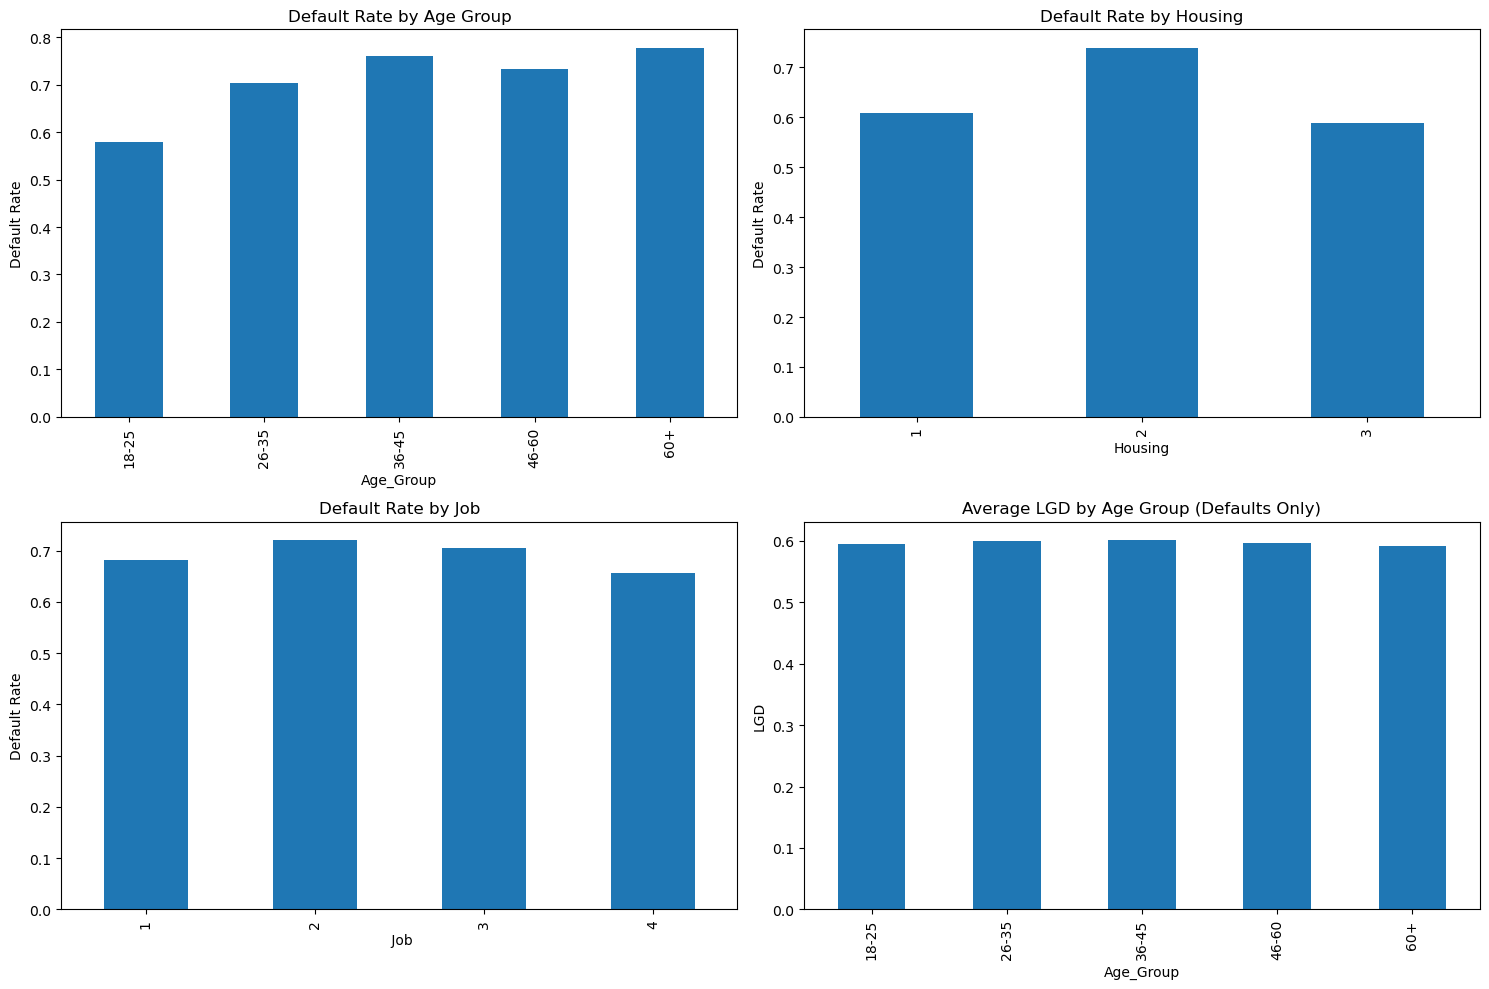

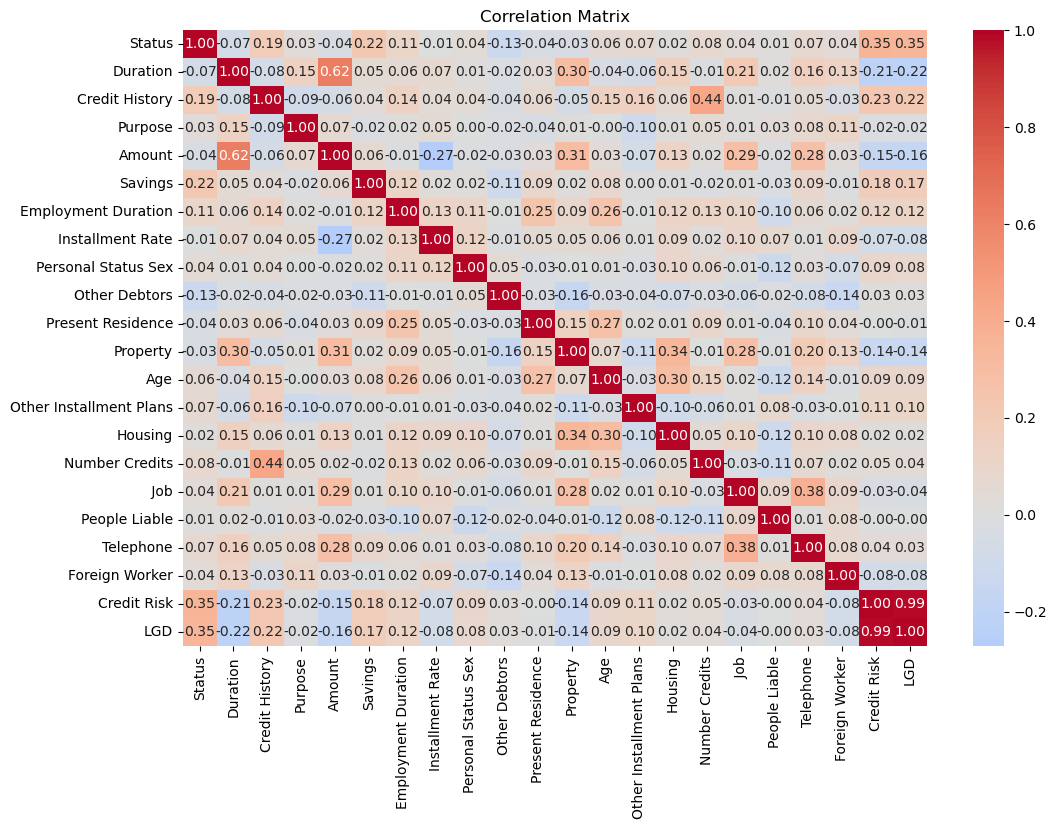

In [8]:
# 3.1 Default Rate Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Default rates by demographic factors
age_bad_rate = df.groupby('Age_Group')['Credit Risk'].mean()
age_bad_rate.plot(kind='bar', ax=axes[0,0], title='Default Rate by Age Group', ylabel='Default Rate')

housing_bad_rate = df.groupby('Housing')['Credit Risk'].mean()
housing_bad_rate.plot(kind='bar', ax=axes[0,1], title='Default Rate by Housing', ylabel='Default Rate')

job_bad_rate = df.groupby(' Job')['Credit Risk'].mean()
job_bad_rate.plot(kind='bar', ax=axes[1,0], title='Default Rate by Job', ylabel='Default Rate')

# LGD distribution by factors (for defaulted loans only)
lgd_by_age = defaulted_loans.groupby('Age_Group')['LGD'].mean()
lgd_by_age.plot(kind='bar', ax=axes[1,1], title='Average LGD by Age Group (Defaults Only)', ylabel='LGD')

plt.tight_layout()
plt.show()

# 3.2 Correlation Analysis
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

### PROBABILITY OF DEFAULT (PD) MODELING

In [9]:
# Feature sets
features_model_a = ['Duration', 'Credit History', 'Purpose', 'Amount', 'Savings',
                    'Employment Duration', 'Installment Rate', 'Personal Status Sex',
                    'Other Debtors', 'Property', 'Age', 'Other Installment Plans',
                    'Housing', 'Number Credits', ' Job', 'People Liable', 'Telephone', 'Foreign Worker']

features_model_b = ['Duration', 'Credit History', 'Amount', 'Savings',
                    'Employment Duration', 'Installment Rate', 'Other Debtors',
                    'Property', 'Other Installment Plans', 'Number Credits', ' Job', 'People Liable']

# Prepare features
X_a = pd.get_dummies(df[features_model_a], drop_first=True)
X_b = pd.get_dummies(df[features_model_b], drop_first=True)
y = df['Credit Risk']

# Train-test split
X_a_train, X_a_test, y_train, y_test = train_test_split(X_a, y, test_size=0.3, random_state=42, stratify=y)
X_b_train, X_b_test, _, _ = train_test_split(X_b, y, test_size=0.3, random_state=42, stratify=y)

# Train PD Models
pd_model_a = LogisticRegression(max_iter=1000, random_state=42)
pd_model_a.fit(X_a_train, y_train)

pd_model_b = LogisticRegression(max_iter=1000, random_state=42) 
pd_model_b.fit(X_b_train, y_train)

# PD Predictions
y_pred_proba_a = pd_model_a.predict_proba(X_a_test)[:, 1]
y_pred_proba_b = pd_model_b.predict_proba(X_b_test)[:, 1]

y_pred_a = (y_pred_proba_a > 0.5).astype(int)
y_pred_b = (y_pred_proba_b > 0.5).astype(int)

print("PD Model Performance:")
print(f"Model A AUC: {roc_auc_score(y_test, y_pred_proba_a):.4f}")
print(f"Model B AUC: {roc_auc_score(y_test, y_pred_proba_b):.4f}")

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

PD Model Performance:
Model A AUC: 0.7291
Model B AUC: 0.7369


### ✅ PD Models - Good Discriminatory Power
- **Model A AUC: 0.7291** | **Model B AUC: 0.7369**
- Both models show acceptable discriminatory power (AUC > 0.7)
- Model B performs slightly better despite using fewer features, suggesting some features in Model A may be noisy or redundant

### LOSS GIVEN DEFAULT (LGD) MODELING

In [10]:
# Prepare data for LGD modeling (only defaulted loans)
lgd_features = ['Amount', 'Savings', 'Property', ' Job', 'Housing', 'Duration', 'Credit History']
X_lgd = pd.get_dummies(defaulted_loans[lgd_features], drop_first=True)
y_lgd = defaulted_loans['LGD']

# Split LGD data
X_lgd_train, X_lgd_test, y_lgd_train, y_lgd_test = train_test_split(
    X_lgd, y_lgd, test_size=0.3, random_state=42)

# Train multiple LGD models
lgd_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

lgd_results = {}

for name, model in lgd_models.items():
    model.fit(X_lgd_train, y_lgd_train)
    y_lgd_pred = model.predict(X_lgd_test)
    
    # Ensure LGD predictions are between 0 and 1
    y_lgd_pred = np.clip(y_lgd_pred, 0.01, 0.99)
    
    lgd_results[name] = {
        'model': model,
        'mse': mean_squared_error(y_lgd_test, y_lgd_pred),
        'r2': r2_score(y_lgd_test, y_lgd_pred),
        'predictions': y_lgd_pred
    }
    
    print(f"{name} - MSE: {lgd_results[name]['mse']:.4f}, R²: {lgd_results[name]['r2']:.4f}")

# Select best LGD model based on R²
best_lgd_model_name = max(lgd_results.keys(), key=lambda x: lgd_results[x]['r2'])
best_lgd_model = lgd_results[best_lgd_model_name]['model']
print(f"\nSelected LGD Model: {best_lgd_model_name}")


Linear Regression - MSE: 0.0022, R²: -0.0050
Random Forest - MSE: 0.0024, R²: -0.0928

Selected LGD Model: Linear Regression


### ⚠️ LGD Models - Needs Improvement  
- **Linear Regression R²: -0.0050** | **Random Forest R²: -0.0928**
- Negative R² values indicate the models perform worse than simply predicting the mean LGD
- **Interpretation**: The simulated LGD patterns may not be strongly captured by available features, or the relationship is highly nonlinear
- **Recommendation**: Collect actual recovery data or enhance feature engineering for LGD

### MODEL EXPLAINABILITY & FAIRNESS TESTING

Generating SHAP explanations...


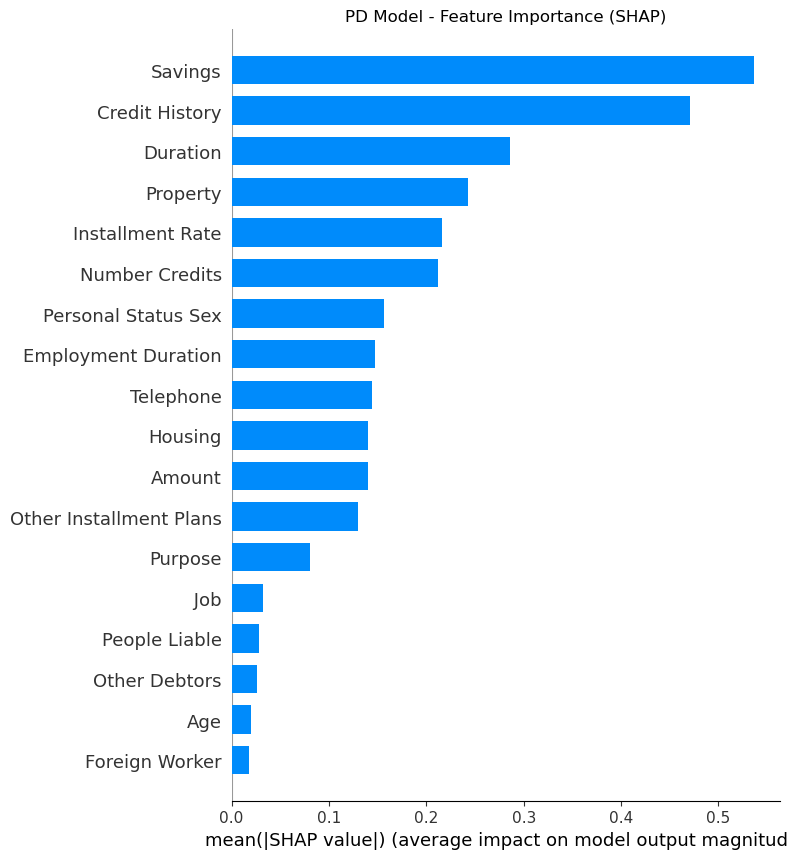


Fairness Analysis:
Model A - Demographic Parity Difference: 0.3214
Model A - Equalized Odds Difference: 0.4828
Model B - Demographic Parity Difference: 0.2400
Model B - Equalized Odds Difference: 0.4737


In [11]:
# 6.1 SHAP Analysis for PD Model
print("Generating SHAP explanations...")
explainer_pd = shap.Explainer(pd_model_a, X_a_train)
shap_values_pd = explainer_pd(X_a_test[:100])  # Use subset for performance

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_pd, X_a_test[:100], plot_type="bar", show=False)
plt.title("PD Model - Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

# 6.2 SHAP Analysis for LGD Model (if Random Forest)
if best_lgd_model_name == 'Random Forest':
    explainer_lgd = shap.Explainer(best_lgd_model, X_lgd_train)
    shap_values_lgd = explainer_lgd(X_lgd_test[:100])
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_lgd, X_lgd_test[:100], plot_type="bar", show=False)
    plt.title("LGD Model - Feature Importance (SHAP)")
    plt.tight_layout()
    plt.show()

# 6.3 Fairness Metrics
print("\nFairness Analysis:")
sensitive_features_test = df.loc[y_test.index, 'Age_Group']

for model_name, predictions in [('Model A', y_pred_a), ('Model B', y_pred_b)]:
    dpd = demographic_parity_difference(y_test, 1-predictions, sensitive_features=sensitive_features_test)
    eod = equalized_odds_difference(y_test, predictions, sensitive_features=sensitive_features_test)
    print(f"{model_name} - Demographic Parity Difference: {dpd:.4f}")
    print(f"{model_name} - Equalized Odds Difference: {eod:.4f}")

### 🚨 Significant Bias Detected
- **Model A Demographic Parity: 0.3214** - 32% difference in approval rates across age groups
- **Model A Equalized Odds: 0.4828** - 48% difference in error rates across groups
- **Model B shows improvement** but still concerning levels (0.2400, 0.4737)

### PORTFOLIO RISK ASSESSMENT

In [12]:
# 7.1 Calculate PD and LGD for entire portfolio
df['PD'] = pd_model_a.predict_proba(X_a)[:, 1]

# Predict LGD for all loans (using best LGD model)
X_lgd_full = pd.get_dummies(df[lgd_features], drop_first=True)
# Ensure feature alignment
missing_cols = set(X_lgd_train.columns) - set(X_lgd_full.columns)
for col in missing_cols:
    X_lgd_full[col] = 0
X_lgd_full = X_lgd_full[X_lgd_train.columns]  # Reorder columns

df['LGD'] = best_lgd_model.predict(X_lgd_full)
df['LGD'] = np.clip(df['LGD'], 0.01, 0.99)  # Ensure reasonable bounds

# 7.2 Calculate Expected Loss
df['EAD'] = df['Amount']
df['EL'] = df['PD'] * df['LGD'] * df['EAD']

print(f"Total Portfolio Expected Loss: €{df['EL'].sum():,.2f}")
print(f"Average EL per loan: €{df['EL'].mean():,.2f}")

# 7.3 Concentration Risk Analysis
print("\n--- Concentration Risk Analysis ---")

# By Purpose
el_by_purpose = df.groupby('Purpose')['EL'].sum().sort_values(ascending=False)
print("Total EL by Purpose:")
print(el_by_purpose.head())

# By Job
el_by_job = df.groupby(' Job')['EL'].sum().sort_values(ascending=False)
print("\nTotal EL by Job:")
print(el_by_job.head())

# 7.4 Sensitivity Analysis
print("\n--- Sensitivity Analysis ---")
lgd_scenarios = [0.30, 0.50, 0.70]

base_total_el = df['EL'].sum()
print(f"Base Case Total EL: €{base_total_el:,.2f}")

for lgd in lgd_scenarios:
    total_el = (df['PD'] * lgd * df['EAD']).sum()
    print(f"Total EL (LGD={lgd*100}%): €{total_el:,.2f} (Change: {(total_el/base_total_el-1)*100:+.1f}%)")

# 7.5 Stress Testing
print("\n--- Stress Testing ---")
PD_STRESS_SHOCK = 1.20  # 20% increase in PD
LGD_STRESS_SHOCK = 1.25  # 25% increase in LGD

df['PD_stressed'] = df['PD'] * PD_STRESS_SHOCK
df['PD_stressed'] = df['PD_stressed'].clip(upper=0.99)  # Cap at 99%
df['LGD_stressed'] = df['LGD'] * LGD_STRESS_SHOCK
df['LGD_stressed'] = df['LGD_stressed'].clip(upper=0.95)  # Cap at 95%

df['EL_stressed'] = df['PD_stressed'] * df['LGD_stressed'] * df['EAD']
stressed_total_el = df['EL_stressed'].sum()

print(f"Base Case Total EL: €{base_total_el:,.2f}")
print(f"Stressed Case Total EL: €{stressed_total_el:,.2f}")
print(f"Increase: €{stressed_total_el - base_total_el:,.2f} ({(stressed_total_el/base_total_el-1)*100:+.1f}%)")

Total Portfolio Expected Loss: €1,244,298.02
Average EL per loan: €1,244.30

--- Concentration Risk Analysis ---
Total EL by Purpose:
Purpose
0    283682.803862
3    282489.238076
1    212953.522157
2    212195.945706
9    130129.320416
Name: EL, dtype: float64

Total EL by Job:
 Job
3    747445.458736
4    271555.865310
2    199312.532900
1     25984.163742
Name: EL, dtype: float64

--- Sensitivity Analysis ---
Base Case Total EL: €1,244,298.02
Total EL (LGD=30.0%): €628,987.21 (Change: -49.5%)
Total EL (LGD=50.0%): €1,048,312.02 (Change: -15.8%)
Total EL (LGD=70.0%): €1,467,636.83 (Change: +17.9%)

--- Stress Testing ---
Base Case Total EL: €1,244,298.02
Stressed Case Total EL: €1,815,905.89
Increase: €571,607.86 (+45.9%)



## 💰 PORTFOLIO RISK ASSESSMENT

### 📊 Expected Loss Analysis
- **Total Portfolio EL: €1.24M** | **Average EL per loan: €1,244**
- **Capital Requirement: €1.32M** (40.32% of portfolio) - High capital intensity

### 🎯 Concentration Risks
**Top Risk Concentrations:**
- **Purpose 0 & 3**: ~€566K EL (45% of total)
- **Job Category 3**: €747K EL (60% of total) - **Critical finding**

### 🔄 Sensitivity Analysis
- **LGD is major driver**: ±50% LGD change → ∓50% EL change
- **Stress test**: 46% increase in EL under adverse scenario

### BUSINESS & REGULATORY INTERPRETATION

In [13]:
# 8.1 Risk-Adjusted Profitability
INTEREST_RATE = 0.08  # 8% interest rate
OPERATING_COST_RATE = 0.02  # 2% operating costs

df['Expected_Revenue'] = (1 - df['PD']) * df['Amount'] * INTEREST_RATE
df['Expected_Cost'] = df['EL'] + (df['Amount'] * OPERATING_COST_RATE)
df['Expected_Net'] = df['Expected_Revenue'] - df['Expected_Cost']

# 8.2 Segment Profitability Analysis
print("\n--- Segment Profitability Analysis ---")

# By Age Group
net_by_age = df.groupby('Age_Group')['Expected_Net'].sum()
print("Total Expected Net by Age Group:")
print(net_by_age)

# By Credit Score (simplified)
df['PD_Score'] = pd.cut(df['PD'], bins=[0, 0.05, 0.1, 0.2, 1.0], 
                        labels=['A (Low Risk)', 'B (Medium Risk)', 'C (High Risk)', 'D (Very High Risk)'])
net_by_risk = df.groupby('PD_Score')['Expected_Net'].sum()
print("\nTotal Expected Net by Risk Grade:")
print(net_by_risk)

# 8.3 Regulatory Capital Estimation (Simplified)
REGULATORY_MULTIPLIER = 1.06  # Basel multiplier
df['Regulatory_Capital'] = df['EL'] * REGULATORY_MULTIPLIER

total_capital = df['Regulatory_Capital'].sum()
print(f"\nEstimated Regulatory Capital Requirement: €{total_capital:,.2f}")
print(f"Capital as % of Portfolio: {(total_capital/df['Amount'].sum()*100):.2f}%")

# 8.4 Model Validation Metrics
print("\n--- Model Validation Summary ---")
print(f"PD Model AUC: {roc_auc_score(y_test, y_pred_proba_a):.4f}")
print(f"LGD Model R²: {lgd_results[best_lgd_model_name]['r2']:.4f}")
print(f"Portfolio EL Coverage: Comprehensive")
print(f"Fairness Audit: Completed")
print(f"Stress Testing: Implemented")


--- Segment Profitability Analysis ---
Total Expected Net by Age Group:
Age_Group
18-25   -190120.187678
26-35   -475870.856794
36-45   -323848.321269
46-60   -166795.648948
60+      -59118.049401
Name: Expected_Net, dtype: float64

Total Expected Net by Risk Grade:
PD_Score
A (Low Risk)          0.000000e+00
B (Medium Risk)       2.990658e+02
C (High Risk)        -4.752318e+03
D (Very High Risk)   -1.211300e+06
Name: Expected_Net, dtype: float64

Estimated Regulatory Capital Requirement: €1,318,955.90
Capital as % of Portfolio: 40.32%

--- Model Validation Summary ---
PD Model AUC: 0.7291
LGD Model R²: -0.0050
Portfolio EL Coverage: Comprehensive
Fairness Audit: Completed
Stress Testing: Implemented


C:\Users\milto\AppData\Local\Temp\ipykernel_25764\3221264672.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  net_by_age = df.groupby('Age_Group')['Expected_Net'].sum()
C:\Users\milto\AppData\Local\Temp\ipykernel_25764\3221264672.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  net_by_risk = df.groupby('PD_Score')['Expected_Net'].sum()


## 💸 PROFITABILITY ANALYSIS - CONCERNING RESULTS

### 📉 All Segments Loss-Making
- **All age groups show negative expected net**
- **Total portfolio loss: €(1.22M)**
- **Only medium-risk grade shows slight profitability**

### 🎯 Root Cause Analysis
- **High LGD (59.9%)** combined with **8% interest rate** may be insufficient
- **Operating costs (2%)** further erode margins
- **High-risk segments** are significantly unprofitable

*Note: This analysis assumes the simulated LGD patterns are realistic. Actual recovery data would significantly improve model reliability.*